In [1]:
#import packages
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pathlib
from torch.utils.data import Dataset

import numpy as np
#from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

In [25]:
#good practice to provide class labels as integer arrays

CLASSES = ["BLD", "No BLD"]
class_mapping = {label: idx for idx, label in
                 enumerate(np.unique([CLASSES]))}


In [4]:
#dictonary to modify transformations
config = dict(
    rot=90,
    noise=0.05
)

In [26]:
#make sure image input size matches expected size for the spcific models

train_transform = transforms.Compose(
    #384x384 for efficientnet
    #224x224 for ResNEt and MobileNEt
    #299x299 for Inception V3 #https://pytorch.org/vision/main/models/generated/torchvision.models.inception_v3.html
    #256x256 for Swin
    [transforms.Resize([224,224]), #converts image to the pre-trained model dimension expectations
     #transforms.RandomRotation(degrees=config["rot"]),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.Grayscale(3),
     transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
    ])

#validation preprocessing
val_transform = transforms.Compose(
    [transforms.Resize([224,224]), #converts image to the pre-trained model dimension expectations
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
     ])
     

In [27]:
#import data
#images in directories converted to tensor format and classes obtained from direcory names
#add test folder once get more data

train_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/train', transform=train_transform)
#test_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/test', transform=val_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/val', transform=val_transform)

In [7]:
# Access the transformed image
image, label = train_dataset[0]
# Check the size of the transformed image
print(image.shape) #retuns [channel, height, width]. 3 indicates color. During training an additional element is added, batch_size


torch.Size([3, 224, 224])


In [8]:
#check class names
train_dataset.class_to_idx

{'BLD': 0, 'No_BLD': 1}

In [9]:
#check number of images in each set
print(f'Number of images in training dataset: {len(train_dataset)}')
#print(f'Number of images in testing dataset: {len(test_dataset)}')
print(f'Number of images in validation dataset: {len(val_dataset)}')

Number of images in training dataset: 82
Number of images in validation dataset: 26


In [28]:
#Bing
#how to print example of each image class from dataset pytorch
#loop through and get one image per class

# Create a dictionary to store one example per class
class_examples = {}

# Iterate through the dataset to find one example per class
#unpack img and label pair from train_dataset
for img, label in train_dataset:
    if label not in class_examples:
        #if the label is not in the class_example dict, then store the image
        class_examples[label] = img
        #if the number of classes in class_examples equals the number of classes in the train_dataset, stop
    if len(class_examples) == len(train_dataset.classes):
        break  

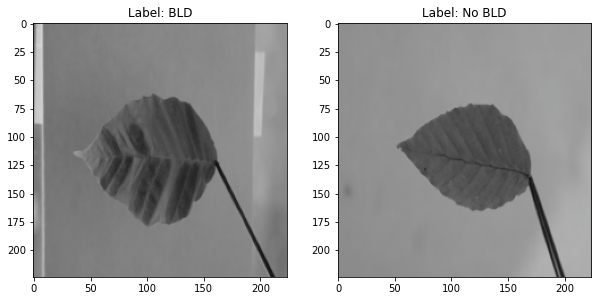

In [29]:
#plot one image from each class in dict 'class_example'
fig = plt.figure(figsize=(10,6))
for label, img in class_examples.items():
    #the dict structure is class label: image
    #print(img)
    #print(label)
    #print(f"Labels batch shape (number): {label.size()}")

    #create subplot shape
    ax = fig.add_subplot(1,2, label+1)
    img = img.numpy().transpose((1, 2, 0)) #changing the channel and dimension order for plotting
    #img = img.numpy().transpose((0, 1, 2))
    #print({img.size})
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    label = label
    ax.imshow(img, cmap="gray")
    #print class title
    ax.set_title(f"Label: {CLASSES[label]}")
plt.show()
   

In [30]:
#a hyperparameter to try changing
#batch_size = 4
batch_size = 16
#batch_size = 32

In [31]:
#dataloader
#output a batch of images and labels, one sample at a time

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                         shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True)



In [15]:
#print class for each sample in batch
train_features, train_labels = next(iter(trainloader))
print(train_labels)

tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0])


Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape (number): torch.Size([16])


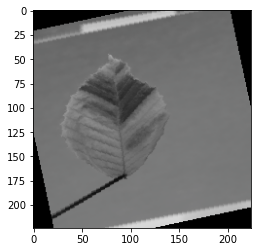

Label: ['BLD']
Label: 0


In [14]:
# Display image and label.
#to pull out a single image and label, first put in individual variables
#https://stackoverflow.com/questions/61480762/python-matplotlib-invalid-shape-for-image-data

train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape (number): {train_labels.size()}")
img = train_features[0].numpy().transpose((1, 2, 0)) #changing the channel and dimension order for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {[CLASSES[label]]}")
print(f"Label: {train_labels[0]}")

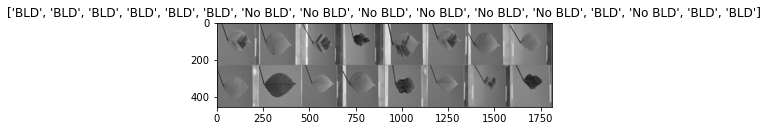

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0])


In [18]:
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[CLASSES[x] for x in classes])
print(classes)

In [35]:
#del model
del optimizer
del criterion




In [32]:
#MobileNet
# Small
weights = MobileNet_V3_Small_Weights.DEFAULT
model_MNs = mobilenet_v3_small(weights = weights)
#model_MNs = mobilenet_v3_small(num_classes=2)


In [33]:
#MobileNet small

#Intitalize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

####################
#MAKE SURE FINAL OUTPUT LAYER FEATURES ARE CORRECT
#for Mobilenet v3 small
##https://stackoverflow.com/questions/57285224/fine-tuning-pretrained-model-mobilenet-v2-in-pytorch
#[0]: Linear(in_features=576, out_features=1024, bias=True)
#[3]: Linear(in_features=1024, out_features=2, bias=True)



##################
#Freeze layers
for param in model_MNs.parameters():
    param.requires_grad = False

#unfreeze last layer
#loss won't be calculated if all layers frozen
for param in model_MNs.classifier.parameters():
    param.requires_grad = True

model_mns = model_MNs


##################
#final layer features
#This can be accomplished by including number of features when loading model
#--> model_MNs = mobilenet_v3_small(num_classes=2)
#OR
#The layer [3] needs to be modified with the number of classes
#the number of output_features in the first layer [0] need to match input_features in the final layer [3] and change out_features of last layer [3] to binary (2)
print(model_MNs.classifier)
num_ftrs_out = model_mns.classifier[0].out_features
print(num_ftrs_out)
num_classes = 2
model_MNs.classifier[3] = nn.Linear(num_ftrs_out, num_classes)
print(f'output features: {model_MNs.classifier[3].out_features}')
################################
#move model to this device
model_mns = model_mns.to(device)

#num_ftrs = model_mns.classifier[0].in_features #print this out to confirm a value
#print(num_ftrs)
#num_ftrs_out = model_mns.classifier[0].out_features
#print(num_ftrs_out)
#num_classes = 2  # Replace with the number of classes in your dataset

#
#print(model_MNs.classifier[1])
#gives the output layer structure that needs to be modified for binary classification
#print(model_MNs.classifier)

#move model to this device
model_mns = model_mns.to(device)



#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_mns.parameters(), lr=0.0001)
#optimizer = optim.Adam(model_mns.fc.parameters(),lr=0.001)


# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)
1024
output features: 2


In [38]:
# clear memory cache
torch.cuda.empty_cache()

In [39]:
#Pg. 479 pytorch book
#modified to accomidate BCELoss format expectations in the pred output
#Pg. 473
#If returning 1 probablity from model(x_batch) (using [:,0]), then use BCE function
#If retunring 2 proabability values, use Cross entropy loss function

def train_1(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            #print(pred.size(), y_batch.size()) #use this to troubleshoot BCE error. Shapes should match
        
        #uncomment block
            loss = criterion(pred, y_batch.float()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float() #calculating correct class from first column of pred tensor [:,0]
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                 #save probabilities from previously trained model
                outputs = model(x_batch)

                #saving largest probabilities in each batch
                probs, preds = torch.max(outputs,1) 
                #print(probs)
                #print(f'preds {preds}')
                #print(f'probs {torch.nn.functional.sigmoid(probs)}')
                
                
               #uncomment block
                loss = criterion(pred, y_batch.float()) #BCE expects floar
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_d1.dataset)
            accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            #Preparing data for evaluation
            #append values in list after loop   
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            #convert to np array  
            #all_preds = np.array(all_preds)
            #all_labels = np.array(all_labels)
            
            #all_preds = torch.tensor(all_preds)
            all_labels = torch.tensor(all_labels)
            print(f' all preds {all_preds}')
            print(f' all labels {all_labels}')
        

            #uncomment block
            print(f'Epoch {epoch+1} ' 
                  f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
                  f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
                  f'train_loss: {loss_hist_train[epoch]:.4f}, '
                  f'val_loss: {loss_hist_valid[epoch]:.4f} ')

            

    # Compute precision
    precision = precision_score(all_labels, all_preds, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
    #calculate recall score
    recall = recall_score(all_labels, all_preds, average='binary')
    #Calculate f1 score
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Calculate ROC AUC
    #need to confirm if sigmoid function is needed (all_predictions vs all_preds
    #auc = roc_auc_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_preds)
        
                    

    print(f'Precision Score: {precision:.4f}, '
          f'Recall Score: {recall:.4f}, '
          f'F1 Score: {f1:.4f}, '
          f'ROC AUC: {auc:.4f}'
            )    

    #for graph
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds) 
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the ROC curve
    #plt.figure()  
    #plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve for Beech Leaf Disease Classification')
    #plt.legend()
    #plt.show()

    #uncomment block
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid, \
        precision, recall, f1, fpr, tpr, auc

In [ ]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 10
hist = train_1(model_mns, num_epochs, trainloader, valloader)

#print(len(hist))
#print(hist[0:9])
#saved variable 'hist' contains the values from each epoch of loss_hist_train [0],
#loss_hist_valid [1], accuracy_hist_train [2], accuracy_hist_valid [3],
#contains single value of precision [4], recall, [5], f1 [6], fpr [7], tpr [8], auc [9]

 all preds [1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
 all labels tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1])
Epoch 1 accuracy: 0.7805, val_accuracy: 0.6154, train_loss: 0.3766, val_loss: 0.5459 
 all preds [0, 1, 1, 0, 1, 1, 0, 0, 1, 0]
 all labels tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1])
Epoch 2 accuracy: 0.7561, val_accuracy: 0.6154, train_loss: 0.3588, val_loss: 0.5311 
 all preds [1, 1, 0, 1, 1, 0, 1, 0, 0, 1]
 all labels tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0])
Epoch 3 accuracy: 0.7683, val_accuracy: 0.6154, train_loss: 0.3447, val_loss: 0.5207 


In [24]:
def train_1(model, num_epochs, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.eval() 
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                #pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                #save probabilities from previously trained model
                outputs = model(x_batch)

                #saving largest probabilities in each batch
                probs, preds = torch.max(outputs,1) 
                print(f'preds {preds}')
                
               # outputs = nn.Sigmoid(outputs)
                #conf, preds = torch.max(outputs, dim=1)
                #print(probs)
                #print(f'preds {preds}')
                # Get the predicted class
                #_, index = torch.max(out, 1)
                #predicted_class = labels[index[0]]
                
                
               #uncomment block
               
                #print(pred)
                #save probabilities from previously trained model
                #outputs = model(x_batch)
                #print(f'Outputs: {outputs} ' )
                #p1 = outputs.size
                #print(f'P1: {p1} ')
                #p2 = torch.sigmoid(outputs)
                #print(f'P2: {p2} ')
                #probs, preds = torch.max(outputs,1)
                #print(f'Preds: {preds} ')
                #pf = torch.sigmoid(preds)
                #print(f'PF: {pf} ')

               # prob = nnf.softmax(outputs, dim=1)
                #top_p, top_class = prob.topk(1, dim = 1)
                #print(top_p)
                #print(top_class)

                
                #outputs = model(x_batch)
                #p, c = torch.max(outputs,1)
                #print(p)
                #print(c)
                #outputs = nn.Softmax(dim=1)(outputs)
                #conf, pred = torch.max(outputs, dim=1)
                #print(f'Prob: {conf} ')
                #print(f'Pred: {pred} ')
                
                #ppp = nn.Sigmoid(pp)
                #print(ppp)
                #probs = pp.numpy()
                #probabilities.extend(probs)
                #saving largest probabilities in each batch
                
                #probabilities = torch.sigmoid(outputs).cpu().numpy()
                #probabilities = torch.sigmoid(outputs)[:, 0]
                #probabilities = F.softmax(outputs, dim=1)[:, 1]
                
                #probs, preds = torch.max(outputs,1) 
                #print(f'Probabilities: {probabilities} ')
                #print(f'Probs: {probs} ')
                #print(f'Preds: {preds}')
                
                
               #uncomment block
                #loss = criterion(pred, y_batch.float()) #BCE expects floar
                #loss_hist_valid[epoch] += \
                #    loss.item() * y_batch.size(0)
                #is_correct = \
                #    ((pred>=0.5).float() == y_batch).float()
                #accuracy_hist_valid[epoch] += is_correct.sum()
            #loss_hist_valid[epoch] /= len(valid_d1.dataset)
            #accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            #Preparing data for evaluation
            #append values in list after loop   
           
            #all_preds.extend(preds.cpu().numpy())
            #all_preds.extend(conf)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            
            #all_labels.extend(y_batch.cpu())
            #convert to np array  
            #all_preds = np.array(all_preds)
            #all_labels = np.array(all_labels)
            
            #all_preds = np.array(all_preds)
            #all_labels = torch.tensor(all_labels)
            #all_labels = all_labels.float()
            
            print(f'All preds: {all_preds} ')
            print(f'All labels: {all_labels}')
        

            #uncomment block
           # print(f'Epoch {epoch+1} ' 
           #       f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
           #       f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
           #       f'train_loss: {loss_hist_train[epoch]:.4f}, '
           #       f'val_loss: {loss_hist_valid[epoch]:.4f} ')

            

    # Compute precision
    #REMOVING "average = 'binary'"
        precision = precision_score(all_labels, all_preds)  # default average = 'binary'. Use 'micro', 'macro', or 'weighted' for multi-class
    #calculate recall score
        recall = recall_score(all_labels, all_preds)
    #Calculate f1 score
        f1 = f1_score(all_labels, all_preds)

    # Calculate ROC AUC
    #need to confirm if sigmoid function is needed (all_predictions vs all_preds
    #auc = roc_auc_score(all_labels, all_predictions)
        auc = roc_auc_score(all_labels, all_preds)
        
                    

        print(f'Precision Score: {precision:.4f}, '
              f'Recall Score: {recall:.4f}, '
              f'F1 Score: {f1:.4f}, '
              f'ROC AUC: {auc:.4f}'
            )    

    #for graph
        fpr, tpr, thresholds = roc_curve(all_labels, all_preds) 
        roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the ROC curve
    #plt.figure()  
    #plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve for Beech Leaf Disease Classification')
    #plt.legend()
    #plt.show()

    #returns these values that can be stored in a variable when the function is run
        return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid, \
            precision, recall, f1, fpr, tpr, auc

In [ ]:
#######################
#
#######################
#need output for predicted class (pred) and true label ie [1,0,1,0] and [1,1,1,0]
#not probability and label





#To get probability and label
#outputs = model(x_batch)
#outputs = nn.Softmax(dim=1)(outputs)
#conf, pred = torch.max(outputs, dim=1)
#Print(f'Prob: {conf} ')
#print(f'Pred: {pred} ')
#all_preds.extend(conf.cpu().numpy())
#all_labels.extend(y_batch.cpu().numpy())

#Next, convert float to integer for probability


#https://github.com/akrapukhin/MobileNetV3/blob/main/test.py
#https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

#outputs = nn.Softmax(dim=1)(outputs)
#conf, pred = torch.max(outputs, dim=1)




#In the validation loop, this code helps illutrate output structure
#outputs = model(x_batch)
#probs = torch.max(outputs,1)
#print(probs)

In [22]:
print(f'Precision Score: {hist[4]}')
print(f'Recall Score: {hist[5]}')
print(f'F1 Score: {hist[6]}')
print(f'False Positive Rate: {hist[7]}')
print(f'True Positive Rate: {hist[8]}')
print(f'ROC AUC: {hist[9]}')

Precision Score: 0.3
Recall Score: 1.0
F1 Score: 0.4615384615384615
False Positive Rate: [0. 1.]
True Positive Rate: [0. 1.]
ROC AUC: 0.5


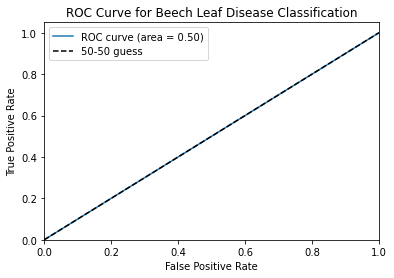

In [23]:
# Plot the ROC curve
#fpr is hist[7]
#tpr is hist[8]
#roc_auc is hist[9]

plt.figure()  
plt.plot(hist[7], hist[8], label='ROC curve (area = %0.2f)' % hist[9])
plt.plot([0, 1], [0, 1], 'k--', label='50-50 guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Beech Leaf Disease Classification')
plt.legend()
plt.show()

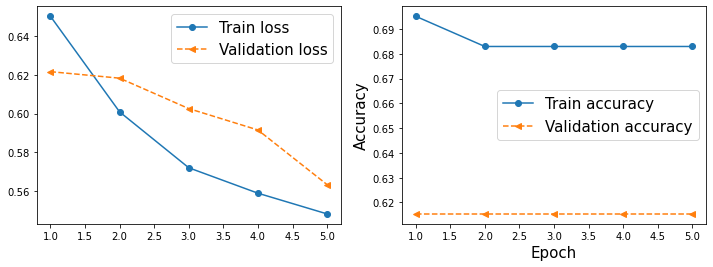

In [24]:
#Plot learning curve
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<',
        label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size=15)
plt.show()


